<a href="https://colab.research.google.com/github/techmehedi/CSC36000-Project-Mehedi-Aidan/blob/main/Updateddemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ============================================================
# Distributed task scheduling demo: Uniform vs SDF vs LARA style
# Everything is in one cell for Google Colab
# ============================================================

# We import numpy for math and random for randomness
import numpy as np
import random

# We import dataclass to define a simple Task object with fields
from dataclasses import dataclass, field

# We import typing tools for type hints (not required to run, just for clarity)
from typing import List, Dict, Callable

# We fix the random seeds so the results are repeatable every time we run the code
random.seed(42)
np.random.seed(42)


In [ ]:
# ------------------------------------------------------------
# Task model
# ------------------------------------------------------------


# We define a Task class that holds all information about one learning task
@dataclass
class Task:
    # Unique id for the task
    tid: int
    # Time step when the task becomes active
    arrival: int
    # Time step when the task must finish by
    deadline: int
    # Target loss value that counts as "good enough"
    eps: float
    # True "a" parameter for the loss curve (hidden from the scheduler)
    true_a: float
    # True "b" parameter for the loss curve (hidden from the scheduler)
    true_b: float
    # Maximum samples this task can process in one time step
    max_rate: float
    # Total samples processed so far
    progress: float = 0.0
    # Flag that becomes True if the task finishes successfully
    done: bool = False
    # Flag that becomes True if the task misses its deadline
    missed: bool = False
    # History of sample counts used for curve fitting
    history_s: List[float] = field(default_factory=list)
    # History of loss values used for curve fitting
    history_l: List[float] = field(default_factory=list)

    # This function computes the true loss given how much progress we made
    def true_loss(self) -> float:
        # Make sure we always have at least 1 sample to avoid log issues
        s = max(self.progress, 1.0)
        # Add a bit of random noise to make it look more realistic
        noise = np.random.normal(loc=0.0, scale=0.02)
        # Use the true loss curve formula: loss = a * s^(-b) + noise
        # We also clip it to a small positive value so it never becomes negative
        return max(self.true_a * (s ** (-self.true_b)) + noise, 1e-4)

    # This function records the current loss into our history so we can fit a curve later
    def observe(self):
        # Get the current noisy loss from the true loss curve
        loss = self.true_loss()
        # Store the current progress (sample count)
        self.history_s.append(max(self.progress, 1.0))
        # Store the current loss
        self.history_l.append(loss)
        # Return the loss in case we want to inspect it
        return loss


In [ ]:
# ------------------------------------------------------------
# Create a small task bundle
# ------------------------------------------------------------

# This function makes a list of tasks with different deadlines and difficulties
def create_tasks(num_tasks: int = 6) -> List[Task]:
    # We will collect all tasks in this list
    tasks = []
    # We set arrival time to 0 for all tasks for simplicity
    t0 = 0

    # We create each task one by one
    for i in range(num_tasks):
        # Randomly choose the true curve parameters for each task
        a = np.random.uniform(0.8, 1.5)
        b = np.random.uniform(0.2, 0.7)

        # Randomly choose a deadline a bit in the future
        deadline = t0 + np.random.randint(20, 45)

        # Set a target loss threshold that this task wants to reach
        eps = np.random.uniform(0.12, 0.22)

        # Set a maximum number of samples the task can consume per time step
        max_rate = np.random.uniform(30, 60)

        # Create the Task object
        task = Task(
            tid=i,
            arrival=t0,
            deadline=deadline,
            eps=eps,
            true_a=a,
            true_b=b,
            max_rate=max_rate,
        )
        # Add this task to the list
        tasks.append(task)

    # Return the full list of tasks
    return tasks



In [ ]:
# ------------------------------------------------------------
# Progress prediction using discounted weighted least squares
# We fit log(loss) = theta0 * log(s) + theta1
# which is the same as loss = a * s^{-b}
# ------------------------------------------------------------

# This function guesses how many more samples a task needs to hit its target loss
def estimate_remaining_samples(task: Task, gamma: float = 0.9) -> float:
    # Convert the stored history of samples to a numpy array
    s_hist = np.array(task.history_s, dtype=float)
    # Convert the stored history of losses to a numpy array
    l_hist = np.array(task.history_l, dtype=float)

    # If we do not have enough past points, we cannot fit a curve yet
    if len(s_hist) < 5:
        # Return a very large number to say "we do not know yet"
        return 1e9

    # Keep only positive values to make log work properly
    mask = (s_hist > 0) & (l_hist > 0)
    s_hist = s_hist[mask]
    l_hist = l_hist[mask]

    # If still not enough points, again say "big number"
    if len(s_hist) < 5:
        return 1e9

    # Take the log of sample counts
    x = np.log(s_hist)
    # Take the log of losses
    y = np.log(l_hist)

    # Number of data points we have
    n = len(x)

    # We make weights that give more importance to recent points
    weights = gamma ** (np.arange(n)[::-1])
    # Turn these weights into a diagonal matrix
    W = np.diag(weights)

    # Our design matrix has two columns: log(s) and 1 (for the bias term)
    X = np.vstack([x, np.ones_like(x)]).T

    try:
        # Compute X transpose * W * X
        XtWX = X.T @ W @ X
        # Compute X transpose * W * y
        XtWy = X.T @ W @ y
        # Solve for theta in the weighted least squares equation
        theta = np.linalg.solve(XtWX, XtWy)

        # From theta we get b_hat and a_hat
        b_hat = -theta[0]
        a_hat = np.exp(theta[1])

        # If our estimated slope b is not positive, we consider the estimate unreliable
        if b_hat <= 0:
            return 1e9

        # We solve for the sample count s where loss hits eps:
        # a_hat * s^{-b_hat} = eps  ->  s = (a_hat / eps)^(1 / b_hat)
        s_target = (a_hat / task.eps) ** (1.0 / b_hat)

        # Remaining samples is target minus what we already processed
        remaining = max(s_target - task.progress, 0.0)

        # If the math goes weird and gives nan or negative, return big number
        if np.isnan(remaining) or remaining < 0:
            return 1e9

        # Return the remaining samples as a normal float
        return float(remaining)

    # If the linear algebra cannot solve the system, return big number
    except np.linalg.LinAlgError:
        return 1e9


In [ ]:
# ------------------------------------------------------------
# Schedulers
# Each scheduler function returns a dict: task_id -> rate_fraction (sum of fractions <= 1)
# We then multiply the fraction by TOTAL_SERVER_POWER to decide how many samples each gets
# ------------------------------------------------------------

# Total capacity of the server per time unit (think of this as total compute budget)
TOTAL_SERVER_POWER = 120.0

# For LARA style, how many samples we spend just exploring each task at the start
EXPLORATION_SAMPLES = 300.0


# This scheduler splits compute equally across all active tasks
def uniform_scheduler(t, tasks, active_ids):
    # If no active tasks, give nothing
    if not active_ids:
        return {}
    # Compute equal fraction for each active task
    frac = 1.0 / len(active_ids)
    # Give the same fraction to every active task
    return {tid: frac for tid in active_ids}


# This scheduler always gives full power to the task with the closest deadline
def shortest_deadline_first_scheduler(t, tasks, active_ids):
    # If no active tasks, give nothing
    if not active_ids:
        return {}
    # Find the task id with the smallest deadline
    best = min(active_ids, key=lambda i: tasks[i].deadline)
    # Give 100 percent of the server to that single task
    return {best: 1.0}


# This scheduler imitates the LARA idea
# It first explores tasks, then uses remaining sample estimates to allocate smartly
def lara_style_scheduler(t, tasks, active_ids):
    # If no active tasks, give nothing
    if not active_ids:
        return {}

    # We first collect tasks that are still in exploration phase
    explore_ids = []
    for tid in active_ids:
        # Look at each task
        task = tasks[tid]
        # If total samples processed so far is less than exploration budget, keep exploring
        if task.progress < EXPLORATION_SAMPLES:
            explore_ids.append(tid)

    # If we still have tasks that need exploration, split power between them equally
    if explore_ids:
        frac = 1.0 / len(explore_ids)
        return {tid: frac for tid in explore_ids}

    # After exploration, we use the estimated remaining samples to allocate smarter
    req_rates = []
    for tid in active_ids:
        # Take the task
        task = tasks[tid]
        # Estimate how many more samples this task needs to reach its target
        remaining = estimate_remaining_samples(task)
        # Compute how much time is left until its deadline
        remaining_time = max(task.deadline - t + 1, 1)
        # Compute the fraction of total server power it would need per time step to finish on time
        req_rate = remaining / (TOTAL_SERVER_POWER * remaining_time)
        # Save the pair (task id, required rate fraction)
        req_rates.append((tid, req_rate))

    # Remove tasks that give weird or zero required rate
    req_rates = [(tid, r) for tid, r in req_rates if r > 0]

    # If nothing left, return empty allocation
    if not req_rates:
        return {}

    # Sort tasks by how little rate they need (smallest required rate first)
    req_rates.sort(key=lambda x: x[1])

    # We will choose tasks while keeping the total fraction under 1
    chosen = []
    used = 0.0
    for tid, r in req_rates:
        # If adding this task keeps us within total capacity, include it
        if used + r <= 1.0:
            chosen.append((tid, r))
            used += r
        else:
            # If including it would exceed capacity, stop
            break

    # Build the final allocation dictionary
    alloc = {}
    for tid, r in chosen:
        # Set the starting allocation as the required rate
        alloc[tid] = r

    # If we have extra unused capacity, distribute it evenly across chosen tasks
    if chosen and used < 1.0:
        extra = (1.0 - used) / len(chosen)
        for tid, _ in chosen:
            alloc[tid] += extra

    # Return the final allocation for this time step
    return alloc


In [ ]:
# ------------------------------------------------------------
# Simulation core
# ------------------------------------------------------------

# This function runs a full simulation of one strategy
def run_simulation(strategy_name: str,
                   scheduler: Callable,
                   horizon: int = 80,
                   verbose: bool = True):
    # First we create a fresh set of tasks
    tasks = create_tasks()
    # Number of tasks
    num_tasks = len(tasks)

    # List of ids of tasks that completed on time
    completed = []
    # We will track which tasks missed, though we do not use this list directly later
    missed = []

    # If verbose, print the strategy name
    if verbose:
        print(f"\n=== Strategy: {strategy_name} ===")

    # We loop over each time step in the simulation
    for t in range(horizon):
        # Find tasks that are active
        # Active means: arrived, not past deadline, not already done, not marked missed
        active_ids = [
            task.tid for task in tasks
            if (task.arrival <= t <= task.deadline)
            and (not task.done)
            and (not task.missed)
        ]

        # Mark tasks as missed if time has gone beyond their deadline
        for task in tasks:
            if not task.done and not task.missed and t > task.deadline:
                # Mark as missed
                task.missed = True
                missed.append(task.tid)
                if verbose:
                    print(f"t={t:2d} Task {task.tid} missed deadline")

        # If nothing is active at this time step, move to next time step
        if not active_ids:
            continue

        # Each active task records its current loss so that we have data for curve fitting
        for tid in active_ids:
            tasks[tid].observe()

        # Ask the scheduler how to split the server power this time step
        allocation = scheduler(t, tasks, active_ids)

        # Apply the allocation to each task
        for tid, frac in allocation.items():
            # Look at the chosen task
            task = tasks[tid]
            # Compute how many samples we actually give it: fraction times total power
            # But we also cap it by the task's max_rate
            power = min(frac * TOTAL_SERVER_POWER, task.max_rate)
            # Increase the progress (sample count) of this task
            task.progress += power

            # If the task is not yet marked as done, we check if it now reaches its target loss
            if not task.done:
                # If current true loss is at or below the target, mark as completed
                if task.true_loss() <= task.eps:
                    task.done = True
                    completed.append(task.tid)
                    if verbose:
                        print(
                            f"t={t:2d} Task {task.tid} completed "
                            f"(progress={task.progress:.1f}, loss≈{task.true_loss():.3f})"
                        )

    # Compute the success rate as percent of tasks that finished
    success_rate = len(completed) / len(tasks) * 100.0

    # Print results if verbose mode is on
    if verbose:
        print("\n--- Results ---")
        print("Completed:", sorted(completed))
        print(
            "Missed   :",
            sorted([i for i in range(num_tasks) if i not in completed])
        )
        print(f"Success rate: {success_rate:.1f} %")

    # Return a dictionary with results so we can use it later
    return {
        "completed": completed,
        "tasks": tasks,
        "success_rate": success_rate,
    }

In [ ]:
# ------------------------------------------------------------
# Run all three strategies and print a summary
# ------------------------------------------------------------

# Run the simulation using Uniform scheduling
res_uniform = run_simulation("Uniform", uniform_scheduler, verbose=True)

# Run the simulation using Shortest Deadline First scheduling
res_sdf = run_simulation("Shortest Deadline First",
                         shortest_deadline_first_scheduler,
                         verbose=True)

# Run the simulation using LARA style adaptive scheduling
res_lara = run_simulation("LARA style", lara_style_scheduler, verbose=True)

# Print a clean summary of success rates for all three strategies
print("\n================ SUMMARY ================")
print(f"Uniform success rate: {res_uniform['success_rate']:.1f} %")
print(f"SDF success rate    : {res_sdf['success_rate']:.1f} %")
print(f"LARA style rate     : {res_lara['success_rate']:.1f} %")


=== Strategy: Uniform ===
t= 0 Task 0 completed (progress=20.0, loss≈0.118)
t= 0 Task 3 completed (progress=20.0, loss≈0.076)
t=12 Task 4 completed (progress=380.0, loss≈0.171)
t=20 Task 1 completed (progress=700.0, loss≈0.194)
t=22 Task 2 missed deadline
t=23 Task 5 completed (progress=878.5, loss≈0.228)

--- Results ---
Completed: [0, 1, 3, 4, 5]
Missed   : [2]
Success rate: 83.3 %

=== Strategy: Shortest Deadline First ===
t= 0 Task 1 completed (progress=44.8, loss≈0.102)
t= 1 Task 0 completed (progress=56.8, loss≈0.098)
t= 2 Task 3 completed (progress=41.1, loss≈0.048)
t= 3 Task 4 completed (progress=47.2, loss≈0.044)
t= 4 Task 2 completed (progress=53.1, loss≈0.061)
t=41 Task 5 missed deadline

--- Results ---
Completed: [0, 1, 2, 3, 4]
Missed   : [5]
Success rate: 83.3 %

=== Strategy: LARA style ===
t= 0 Task 1 completed (progress=20.0, loss≈0.182)
t= 0 Task 2 completed (progress=20.0, loss≈0.227)
t= 1 Task 0 completed (progress=50.0, loss≈0.188)
t= 2 Task 5 completed (progress

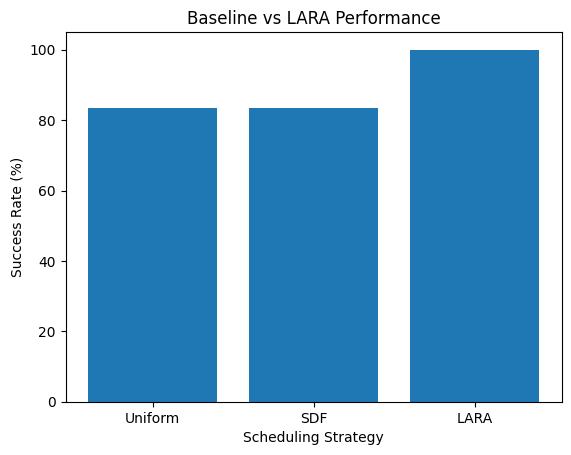

In [ ]:
import matplotlib.pyplot as plt

labels = ["Uniform", "SDF", "LARA"]
rates = [
    res_uniform['success_rate'],
    res_sdf['success_rate'],
    res_lara['success_rate']
]

plt.bar(labels, rates)
plt.xlabel("Scheduling Strategy")
plt.ylabel("Success Rate (%)")
plt.title("Baseline vs LARA Performance")
plt.show()
